# Trajectory Planning for Closed Kinematic Chains (7-Link Model)

## Setup

### Package imports

In [1]:
%load_ext ipydex.displaytools
%matplotlib inline

import math
import ipydex
import sympy as sp
import numpy as npy  # we need `np` later 
from sympy import sin, cos, pi
from sympy.interactive import printing
import symbtools as st
import symbtools.modeltools as mt
from symbtools.modeltools import Rz # rotation matrix in the xy plane (c, -s; s, c)
import scipy.integrate as sc_integrate
import scipy.optimize
import matplotlib.pyplot as plt
from cycler import cycler


printing.init_printing(1)

### Symbolic variables and coordinates

In [2]:
t = sp.Symbol('t')  # time variable
np = 2
nq = 2
ns = 2
n = np + nq + ns 

pp = st.symb_vector("p1:{0}".format(np+1))
qq = st.symb_vector("q1:{0}".format(nq+1))
ss = st.symb_vector("s1:{0}".format(ns+1))

ttheta = st.row_stack(qq[0], pp[0], ss[0], qq[1], pp[1], ss[1]) ##:T
tthetad = st.time_deriv(ttheta, ttheta) ##:T
tthetadd = st.time_deriv(ttheta, ttheta, order=2) ##:T

ttheta_all = st.concat_rows (ttheta, tthetad, tthetadd) ##:T

st.make_global(ttheta, tthetad, tthetadd)

params = sp.symbols('c1, c2, c3, c4, c5, c6, m1, m2, m3, m4, m5, m6, J1, J2, J3, J4, J5, J6, l1, l2, l3, l4, l5, l6, d, g')
st.make_global(params)

tau1, tau2, tau3, tau4, tau5, tau6 = ttau = st.symb_vector("tau1, tau2, tau3, tau4, tau5, tau6 ")

---

---

---

---

Coordinates of centers of mass and joints

---

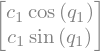

---

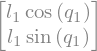

---

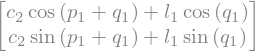

---

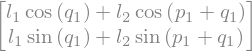

---

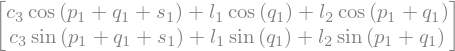

---

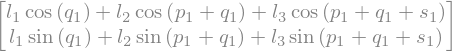

---

---

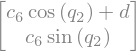

---

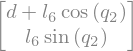

---

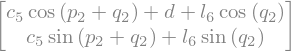

---

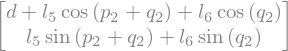

---

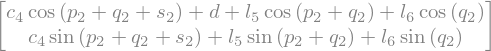

---

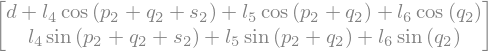

---

In [3]:
# unit vectors

ex = sp.Matrix([1, 0]) 
ey = sp.Matrix([0, 1]) 

# coordinates of centers of mass and joints
# left
G0 = 0*ex##:

C1 = G0 + Rz(q1)*ex*c1 ##:

G1 = G0 + Rz(q1)*ex*l1 ##:

C2 = G1 + Rz(q1 + p1)*ex*c2 ##:

G2 = G1 + Rz(q1 + p1)*ex*l2 ##:

C3 = G2 + Rz(q1 + p1 + s1)*ex*c3 ##:

G3 = G2 + Rz(q1 + p1 + s1)*ex*l3 ##:

# right
G6 = d*ex ##:

C6 = G6 + Rz(q2)*ex*c6 ##:

G5 = G6 + Rz(q2)*ex*l6 ##:

C5 = G5 + Rz(q2 + p2)*ex*c5 ##:

G4 = G5 + Rz(q2 + p2)*ex*l5 ##:

C4 = G4 + Rz(q2 + p2 + s2)*ex*c4 ##:

G3b = G4 + Rz(q2 + p2 + s2)*ex*l4 ##:

# time derivatives of centers of mass
Sd1, Sd2, Sd3, Sd4, Sd5, Sd6 = st.col_split(st.time_deriv(st.col_stack(C1, C2, C3, C4, C5, C6), ttheta))

In [4]:
# Kinetic Energy (note that angles are relative)

T_rot = (J1*qdot1**2)/2 + (J2*(qdot1 + pdot1)**2)/2 + (J3*(qdot1 + pdot1 + sdot1)**2)/2 + \
        (J4*(qdot2 + pdot2 + sdot2)**2)/2 + (J5*(qdot2 + pdot2)**2)/2 + (J6*qdot2**2)/2
T_trans = ( m1*Sd1.T*Sd1  +  m2*Sd2.T*Sd2 + m3*Sd3.T*Sd3 + m4*Sd4.T*Sd4  +  m5*Sd5.T*Sd5 + m6*Sd6.T*Sd6)/2 

T = T_rot + T_trans[0] 

# Potential Energy
V = m1*g*C1[1] + m2*g*C2[1] + m3*g*C3[1]+ m4*g*C4[1] + m5*g*C5[1] + m6*g*C6[1]

In [5]:
parameter_values = list(dict(c1=0.4/2, c2=0.42/2, c3=0.55/2, c4=0.55/2, c5=0.42/2, c6=0.4/2,
                             m1=6.0, m2=12.0, m3=39.6, m4=39.6, m5=12.0, m6=6.0,
                             J1=(6*0.4**2)/12, J2=(12*0.42**2)/12, J3=(39.6*0.55**2)/12, 
                             J4=(39.6*0.55**2)/12, J5=(12*0.42**2)/12, J6=(6*0.4**2)/12,
                             l1=0.4, l2=0.42, l3=0.55, l4=0.55, l5=0.42, l6=0.4, d=0.26, g=9.81).items())

### Symbolic DAE model

In [6]:
# Generate symbolic DAE model, or load from file if possible
external_forces = [tau1, tau2, tau3, tau4, tau5, tau6]

import pickle
import os

fname = "7L-dae-2020-07-15.pcl"

if not os.path.isfile(fname):
    %time mod = mt.generate_symbolic_model(T, V, ttheta, external_forces, constraints=[G3 - G3b])
    %time mod.calc_state_eq(simplify=False)

    %time mod.f_sympy = mod.f.subs(parameter_values) 
    %time mod.G_sympy = mod.g.subs(parameter_values) 
    with open(fname, "wb") as pfile:
        pickle.dump(mod, pfile)
else:
    with open(fname, "rb") as pfile:
        mod = pickle.load(pfile)

## DAE System

### initial state

In [7]:
# calculate DAE equations from symbolic model
dae = mod.calc_dae_eq(parameter_values)

dae.generate_eqns_funcs()

Calculate consistent initial and final states, these are then copy-pasted into the code below

In [8]:
# initial condition
yy0, yyd0 = dae.calc_consistent_init_vals(q1= 1.0, p1= 1.8, q2= 2.1, p2= -1.85) ##:

t0 = 0

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 94
         Function evaluations: 183
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 31
         Function evaluations: 63


(yy0, yyd0) := (array([ 1.        ,  1.8       , -1.89957181,  2.1       , -1.85      ,  1.90406705,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  8.97746494,  0.04975741]),
 array([  0.        ,   0.        ,   0.        ,   0.        ,   0.        ,   0.        , -10.25291402,  31.0177518 , -19.54200333,   8.41969468, -29.94415943,  20.05828417,   0.        ,   0.        ]))

---

In [9]:
# final condition
yye, yyde = dae.calc_consistent_init_vals(q1= npy.pi/2, p1= 0, q2= npy.pi/2, p2= 0) ##:

t0 = 0

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 82
         Function evaluations: 158
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 32
         Function evaluations: 65


(yye, yyde) := (array([ 1.57079633e+00,  0.00000000e+00, -2.38621734e-01,  1.57079633e+00,  0.00000000e+00,  2.38621730e-01,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -6.31289509e+01,  1.95839323e-06]),
 array([  0.        ,   0.        ,   0.        ,   0.        ,   0.        ,   0.        ,  -2.27409765,  10.93732678, -13.76958704,   2.27409767, -10.93732687,  13.76958719,  -0.        ,   0.        ]))

---

### Setup kinematic visualisation

In [10]:
import symbtools.visualisation as vt

torso1_unit = Rz(q1 + p1 + s1)*ex
torso2_unit = Rz(q2 + p2 + s2)*ex

neck_length = 0.12
head_radius = 0.1

body_width = 15
neck_width = 15

H1 = G3 + neck_length * torso1_unit
H1r = G3 + (neck_length - head_radius) * torso1_unit
H2 = G3b + neck_length * torso2_unit
H2r = G3b + (neck_length - head_radius) * torso2_unit

vis = vt.Visualiser(ttheta, xlim=(-1.5, 1.5), ylim=(-.2, 2))

# get default colors and set them explicitly
# this prevents color changes in onion skin plot
default_colors = plt.get_cmap("tab10")
guy1_color = default_colors(0)
guy1_joint_color = "darkblue"
guy2_color = default_colors(1)
guy2_joint_color = "red"
guy1_head_fc = guy1_color  # facecolor
guy1_head_ec = guy1_head_fc  # edgecolor
guy2_head_fc = guy2_color  # facecolor
guy2_head_ec = guy2_head_fc  # edgecolor

# guy 1 body
vis.add_linkage(st.col_stack(G0, G1, G2, G3).subs(parameter_values),
                color=guy1_color,
                solid_capstyle='round',
                lw=body_width,
                ms=body_width,
                mfc=guy1_joint_color)
# guy 1 neck
#vis.add_linkage(st.col_stack(G3, H1r).subs(parameter_values), color=head_color, solid_capstyle='round', lw=neck_width)
# guy 1 head
vis.add_disk(st.col_stack(H1, H1r).subs(parameter_values), fc=guy1_head_fc, ec=guy1_head_ec, plot_radius=False, fill=True)

# guy 2 body
vis.add_linkage(st.col_stack(G6, G5, G4, G3b).subs(parameter_values),
                color=guy2_color,
                solid_capstyle='round',
                lw=body_width,
                ms=body_width,
                mfc=guy2_joint_color)
# guy 2 neck
#vis.add_linkage(st.col_stack(G3b, H2r).subs(parameter_values), color=head_color, solid_capstyle='round', lw=neck_width)
# guy 2 head
vis.add_disk(st.col_stack(H2, H2r).subs(parameter_values), fc=guy2_head_fc, ec=guy2_head_ec, plot_radius=False, fill=True)

In [11]:
# use inital values for visualization
kwargs = dict([(var.name, (-4, 4, .1, yy0[i])) for i, var in enumerate(mod.tt)])

# define constraints for visualisation
cnstrs = mod.constraints.subs(parameter_values)

# uncomment for interactive kinematic motion
#vis.interact(free_vars=(q1, p1, s1, q2), constraints=cnstrs, **kwargs)

Set consistent initial state read from interactive visualisation for further simulations

In [12]:
# meaningful initial values: [1.0, 1.8, -1.9, 2.1, -1.851, 1.91]

ttheta_start = npy.r_[1.0, 1.8, -1.8995718078681274, 2.1, -1.85, 1.90406705183088]
ttheta_start = npy.r_[0.9, 1.5, -1.9, 2.1, -2.175799453493845, 1.7471971159642905]

In [13]:
eq_stat = mod.eqns.subz0(tthetadd).subz0(tthetad).subs(parameter_values) ##:i

info(eq_stat) := "<class 'sympy.matrices.dense.MutableDenseMatrix'> with count_ops: Matrix([[43], [32], [18], [43], [32], [18]])"

---


These equations are of the form:

$K_1(\theta) \cdot \mu + K_0(\theta) = 0$


Matrix K1 is not square. There are more free parameters in $\mu$ (8) than equality constraints (6). This means there are infinitely many solutions. To get a unique solution we search for the vector $\mu$ that minimizes the cost function $\mu^T \bar Q \mu$. This can be reached by solving a system of linear equations (<https://en.wikipedia.org/wiki/Quadratic_programming#Equality_constraints>): 

In [14]:
# vector for tau and lambda together

ttau_symbols = sp.Matrix(mod.uu) ##:T

mmu = st.row_stack(ttau_symbols, mod.llmd) ##:T

# linear system of equations (and convert to function w.r.t. ttheta)

K0_expr = eq_stat.subz0(mmu) ##:i
K1_expr = eq_stat.jacobian(mmu) ##:i

K0_func = st.expr_to_func(ttheta, K0_expr)
K1_func = st.expr_to_func(ttheta, K1_expr, keep_shape=True)

---

---

info(K0_expr) := "<class 'sympy.matrices.dense.MutableDenseMatrix'> with count_ops: Matrix([[12], [9], [5], [12], [9], [5]])"

---

info(K1_expr) := "<class 'sympy.matrices.dense.MutableDenseMatrix'> with count_ops: Matrix([[2, 0, 0, 0, 0, 0, 12, 13], [0, 2, 0, 0, 0, 0, 9, 10], [0, 0, 2, 0, 0, 0, 5, 6], [0, 0, 0, 2, 0, 0, 13, 12], [0, 0, 0, 0, 2, 0, 10, 9], [0, 0, 0, 0, 0, 2, 6, 5]])"

---



\begin{align*}
%\label{eq_}
&{\text{Minimize}}\quad {\tfrac {1}{2}}\mathbf {\mu} ^{\mathrm {T} }\bar R\mathbf {\mu} +\mathbf {c} ^{\mathrm {T} }\mathbf {\mu} \\
&{\text{subject to}}\quad K_1\mathbf {\mu} =-\mathbf {K}_0 
\end{align*}

Solution is given by the solution of this system:
$$
{\begin{bmatrix}\bar R&K_1^{T}\\K_1&0\end{bmatrix}}{\begin{bmatrix}\mathbf {\mu} \\
\bar \lambda \end{bmatrix}}={\begin{bmatrix}-\mathbf {c} \\\mathbf {-K}_0 \end{bmatrix}}
$$


In [15]:

def get_mu_stat_for_theta(ttheta_arg, rho=10):
    # weighting matrix for mu
    

    K0 = K0_func(*ttheta_arg)
    K1 = K1_func(*ttheta_arg)
    
    
    return solve_qlp(K0, K1, rho)

def solve_qlp(K0, K1, rho):
    R_mu = npy.diag([1, 1, 1,  rho, rho, rho, .1, .1])
    n1, n2 = K1.shape
    
    
    # construct the equation system for least squares with linear constraints
    M1 = npy.column_stack((R_mu, K1.T))
    M2 = npy.column_stack((K1, npy.zeros((n1, n1)) ))
    M_coeff = npy.row_stack((M1, M2))

    M_rhs = npy.concatenate((npy.zeros(n2), -K0))

    mmu_stat = npy.linalg.solve(M_coeff, M_rhs)[:n2]
    return mmu_stat

In [16]:
mmu_start = get_mu_stat_for_theta(ttheta_start) ##:

# check whether "equations of motion" are met for equilibrium

assert npy.allclose(st.to_np(eq_stat.subz(ttheta, ttheta_start).subz(mmu, mmu_start)), 0 )

mmu_start := array([ 226.94405323,   17.54374126,  231.97234592,    0.33301116,   63.54757767,  -11.23299731,   28.26797202, -270.9210992 ])

---

In [17]:
connection_point_func = st.expr_to_func(ttheta, G3.subs(parameter_values))

In [18]:
# solve stationary optimization problem using Casadi
import casadi as cs

from casadi import SX, inf
import symbtools.mpctools as mpc



In [19]:
cs_ttau = mpc.casidify(mod.uu, mod.uu)[0]
cs_llmd = mpc.casidify(mod.llmd, mod.llmd)[0]

controls_sp = mmu
controls_cs = cs.vertcat(cs_ttau, cs_llmd) ##:
coords_cs, _ = mpc.casidify(ttheta, ttheta)

controls_cs := SX([tau1, tau2, tau3, tau4, tau5, tau6, lambda_1, lambda_2])

---

In [20]:

# parameters: 0: value of y_connection, 1: x_connection_last,
# 2: y_connection_last, 3: delta_r_max, 4: rho (penalty factor for 2nd persons torques),
# 5:11: ttheta_old[6], 11:17: ttheta:old2
# 
P = SX.sym('P', 5+12)
rho = P[10]

# weightning of inputs
R = mpc.SX_diag_matrix((1, 1, 1,   rho, rho, rho,  0.1, 0.1))


#  Construction of Constraints

g1 = []  # constraints vector (system dynamics)
g2 = []  # inequality-constraints 


closed_chain_constraint, _ = mpc.casidify(mod.dae.constraints, ttheta, cs_vars=coords_cs)
connection_position, _ = mpc.casidify(list(G3.subs(parameter_values)), ttheta, cs_vars=coords_cs) ##:i
connection_y_value, _ = mpc.casidify([G3[1].subs(parameter_values)], ttheta, cs_vars=coords_cs)##:i

stationary_eqns, _, _ = mpc.casidify(eq_stat, ttheta, controls_sp, cs_vars=(coords_cs, controls_cs)) ##:i


g1.extend(mpc.unpack(stationary_eqns))
g1.extend(mpc.unpack(closed_chain_constraint))

# force the connecting joint to a given hight (which will be provided later)
g1.append(connection_y_value - P[0])

ng1 = len(g1) ##:




# squared distance from the last reference should be smaller than P[3] (delta_r_max):
# this will be a restriction between -inf and 0
r = connection_position - P[1:3]
g2.append(r.T@r-P[3])

# change of angles should be smaller than a given bound (P[5:11] are the old coords)
coords_old = P[5:11]
coords_old2 = P[11:17]
pseudo_vel = (coords_cs-coords_old) / 1
pseudo_acc = (coords_cs-2*coords_old + coords_old2) / 1

g2.extend(mpc.unpack(pseudo_vel))
g2.extend(mpc.unpack(pseudo_acc))

g_all = mpc.seq_to_SX_matrix(g1 + g2) ##:S


### Construction of objective Function 

obj = controls_cs.T@R@controls_cs + 1e5 *pseudo_acc.T@pseudo_acc + 0.3e6*pseudo_vel.T@pseudo_vel

OPT_variables  = cs.vertcat(coords_cs, controls_cs) ##:S

# for debugging
g_all_cs_func = cs.Function("g_all_cs_func", (OPT_variables, P), (g_all,)) ##:

info((connection_position, _)) := "<class 'tuple'> with length: 2"

---

info((connection_y_value, _)) := "<class 'tuple'> with length: 2"

---

info((stationary_eqns, _, _)) := "<class 'tuple'> with length: 3"

---

---

---

---

g_all_cs_func := Function(g_all_cs_func:(i0[14],i1[17])->(o0[22]) SXFunction)

---

In [21]:
nlp_prob = dict(f=obj, x=OPT_variables, g=g_all, p=P)

ipopt_settings = dict(max_iter=5000, print_level=0,
                      acceptable_tol=1e-8, acceptable_obj_change_tol = 1e-6)
opts = dict(print_time=False, ipopt=ipopt_settings)


In [22]:
xx_guess = npy.r_[ttheta_start, mmu_start]

# note: g1 contains the equality constraints (system dynamics) (lower bound = upper bound)

delta_phi = .05
d_delta_phi = .02
eps = 1e-9
lbg = npy.r_[ [-eps]*ng1 + [-inf] + [-delta_phi]*n,  [-d_delta_phi]*n ]
ubg = npy.r_[ [eps]*ng1 + [0] + [delta_phi]*n,  [d_delta_phi]*n ]


# ubx = [inf]*OPT_variables.shape[0]##:

# lower and upper bounds for decision variables:
#lbx = [-inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf]*N1 + [tau1_min, tau4_min, -inf, -inf]*N
#ubx = [inf, inf, inf, inf, inf, inf, inf, inf]*N1 + [tau1_max, tau4_max, inf, inf]*N

rho = 3
P_init = npy.r_[connection_point_func(*ttheta_start)[1],
                connection_point_func(*ttheta_start), 0.01, rho, ttheta_start, ttheta_start]

args = dict(lbx=-inf, ubx=inf, lbg=lbg, ubg=ubg,  # unconstrained optimization
            p=P_init,  # initial and final state
            x0=xx_guess   # initial guess
           )

In [23]:
%time solver = cs.nlpsol("solver", "ipopt", nlp_prob, opts)

CPU times: user 9.97 ms, sys: 138 µs, total: 10.1 ms
Wall time: 10.1 ms


In [24]:
%time sol = solver(**args)

stats = solver.stats()
stats['success']
stats['return_status']


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

CPU times: user 9.78 ms, sys: 125 µs, total: 9.91 ms
Wall time: 9.77 ms


'Solve_Succeeded'

In [25]:
global_vars = ipydex.Container(old_sol=xx_guess, old_sol2=xx_guess)

def get_optimal_equilibrium(y_value, rho=3):
    
    ttheta_old = global_vars.old_sol[:n]
    ttheta_old2 = global_vars.old_sol2[:n]
    opt_prob_params = npy.r_[y_value, connection_point_func(*ttheta_old),
                             0.01, rho, ttheta_old, ttheta_old2]
    
    args.update(dict(p=opt_prob_params, x0=global_vars.old_sol))
    sol = solver(**args)
    
    stats = solver.stats()
    if not stats['success']:
        raise ValueError(stats["return_status"])
    
    XX = sol["x"].full().squeeze()
    
    # save the last two results
    global_vars.old_sol2 = global_vars.old_sol
    global_vars.old_sol = XX

    return XX

Visualization of $y_\mathrm{E}$-values

In [26]:
import copy

orig_plt_rcParams = copy.deepcopy(plt.rcParams)

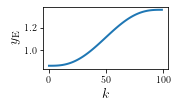

In [27]:
y_start = connection_point_func(*ttheta_start)[1]
N = 100

y_end = 1.36
y_func = st.expr_to_func(t, st.condition_poly(t, (0, y_start, 0, 0), (1, y_end, 0, 0)))

plt.rcParams['text.usetex'] = True

plt.rcParams['figure.subplot.left'] = .21
plt.rcParams['figure.subplot.bottom'] = .31

tt = npy.linspace(0, 1, N)
kk = npy.arange(N)
fs = npy.array((5, 3))*0.5
plt.figure(figsize=fs)
plt.plot(kk, y_func(tt), lw="2")
plt.ylabel(r"$y_\mathrm{E}$", fontsize=14)
plt.xlabel(r"$k$", fontsize=14)
plt.savefig("yE_pseudo_time.pdf")

In [28]:
def get_qs_trajectory(rho):
    # measure the time of the whole cell
    
    # 
    pseudo_time = npy.linspace(0, 1, N)
    yy_connection = y_func(pseudo_time)
    
    # reset the initial guess
    global_vars.old_sol = xx_guess
    global_vars.old_sol2 = xx_guess
    XX_list = []
    for i, y_value in enumerate(yy_connection):
        #print(i, y_value)
        XX_list.append(get_optimal_equilibrium(y_value, rho=rho))

    XX = npy.array(XX_list)
    return XX




In [29]:
# for blue: https://paletton.com/#uid=53w0k0ksfALhxKKmVEJ-1u5AGnd
# for orange: https://paletton.com/#uid=50w0k0kufw0iJEJnYz3x4pFByke

color_cycle = cycler(color=['#15B494', '#1F77B4', '#294BBB', '#FFA30E', '#ff7f0e', '#FF480E'])

def plot_results(XX):
    ttheta_num = XX[:, :n]
    ttau_num = XX[:, n:-2]
    N = XX.shape[0]
    # introduce some fake time (because we calculated quasistationary)
    tt = npy.linspace(0, 2, N)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    



    ax1.set_prop_cycle(color_cycle)
    ax2.set_prop_cycle(color_cycle)

    ax1.plot(tt, ttheta_num)

    ax2.plot(tt, ttau_num[:, :3], label="active person")
    ax2.plot(tt, ttau_num[:, 3:], "--", label="passive person")
    ax2.legend()
    
    return tt

CPU times: user 611 ms, sys: 80.2 ms, total: 691 ms
Wall time: 691 ms


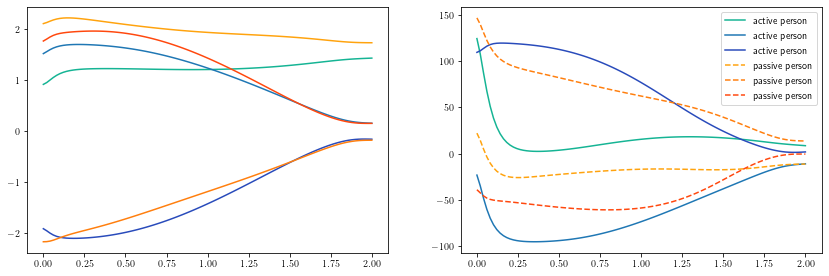

In [30]:
%%time

# XX = get_qs_trajectory(rho=3)
# tt = plot_results(XX)

rho = 30
XX = get_qs_trajectory(rho=rho)
tt = plot_results(XX)

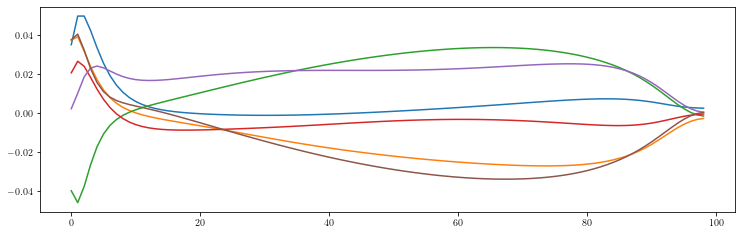

In [31]:
# for debugging: look at the changerates for ttheta

ttheta_num = XX[:, :n]

plt.figure(figsize=(14, 5))

plt.plot(npy.diff(ttheta_num, axis=0))

# npy.diff?

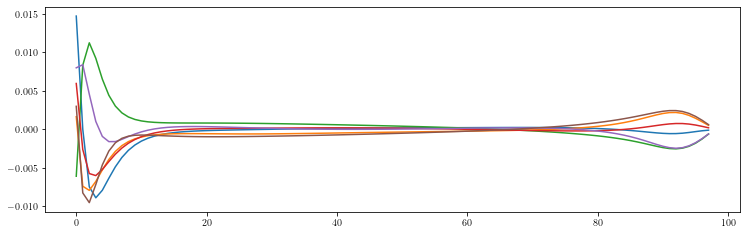

In [32]:
# for debugging: look at the changerates for ttheta

ttheta_num = XX[:, :n]

plt.figure(figsize=(14, 5))

plt.plot(npy.diff(ttheta_num, axis=0, n=2) )

# npy.diff?

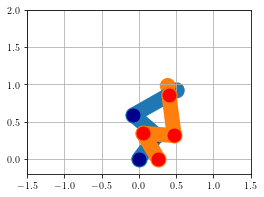

In [33]:
simanim = vt.SimAnimation(ttheta, tt, XX[:, :n])
simanim.add_visualiser(vis)


simanim.display_frame(0)

# uncomment to display animation
# simanim.display() # thins increases the notebooksize and should be avoided for repo-checkins

## Time scaling of the quasistationary solution

In [34]:

def smooth_time_scaling(Tend, N, phase_fraction=.5):
    """
    :param Tend:
    :param N:
    :param phase_fraction:   fraction of Tend for smooth initial and end phase
    """
    
    T0 = 0
    T1 = Tend*phase_fraction

    y0 = 0
    y1 = 1


    # for initial phase
    poly1 = st.condition_poly(t, (T0, y0, 0, 0), (T1, y1, 0, 0))
    
    # for end phase
    poly2 = poly1.subs(t, Tend-t)
    

    # there should be a phase in the middle with constant slope 
    deriv_transition = st.piece_wise((y0, t < T0), (poly1, t<T1), (y1, t<Tend-T1),
                                    (poly2, t<Tend), (y0, True))
    
    scaling = sp.integrate(deriv_transition, (t, T0, Tend))
    
    time_transition = sp.integrate(deriv_transition*N/scaling, t)
    
    # deriv_transition_func = st.expr_to_func(t, full_transition)
    time_transition_func = st.expr_to_func(t, time_transition)
    deriv_func = st.expr_to_func(t, deriv_transition*N/scaling)
    deriv_func2 = st.expr_to_func(t, deriv_transition.diff(t)*N/scaling)
    
    C = ipydex.Container(fetch_locals=True)
    
    return C

In [35]:
N = XX.shape[0]
Tend = 4
res = smooth_time_scaling(Tend, N)

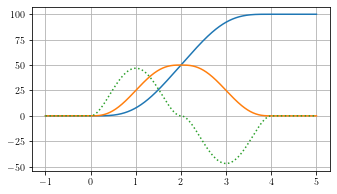

In [36]:
tt2 = npy.linspace(res.T0-1, res.Tend+1, 1000)

plt.plot(tt2, res.time_transition_func(tt2), '-')
plt.plot(tt2, res.deriv_func(tt2), '-')
plt.plot(tt2, res.deriv_func2(tt2), ':')
# plt.axis([-3, 5, -1, N*1.1])
plt.grid()

#### Using this scaling we now calculate $\dot \theta$ and $\ddot \theta$

In [37]:
from scipy.interpolate import splrep, splev, interp1d

def get_derivatives(XX, time_scaling, res=100):
    """
    :param XX:             Nxm array 
    :param time_scaling:   container for time scaling
    :param res:            time resolution of the returned arrays
    """
    
    N = XX.shape[0]
    Tend = time_scaling.Tend
    assert npy.isclose(time_scaling.time_transition_func([0, Tend])[-1], N)
    
    tt = npy.linspace(time_scaling.T0, time_scaling.Tend, res)
    NN = npy.arange(N)
    
    # high_resolution version of index arry
    NN2 = npy.linspace(0, N, res, endpoint=False)
    
    # time-scaled verion of index-array
    NN3 = time_scaling.time_transition_func(tt)
    NN3d = time_scaling.deriv_func(tt)
    NN3dd = time_scaling.deriv_func2(tt)
    
    XX_num, XXd_num, XXdd_num = [], [], []
    
    # iterate over every column
    for col in XX.T:
        spl = splrep(NN, col)
        
        # function value and derivatives
        XX_num.append(splev(NN3, spl))
        XXd_num.append(splev(NN3, spl, der=1))
        XXdd_num.append(splev(NN3, spl, der=2))

    XX_num = npy.array(XX_num).T
    XXd_num = npy.array(XXd_num).T
    XXdd_num = npy.array(XXdd_num).T
    
    NN3d_bc = npy.broadcast_to(NN3d, XX_num.T.shape).T
    NN3dd_bc = npy.broadcast_to(NN3dd, XX_num.T.shape).T
    
    XXd_n = XXd_num*NN3d_bc
    
    # apply chain rule
    XXdd_n = XXdd_num*NN3d_bc**2 + XXd_num*NN3dd_bc
    
    
    
    C = ipydex.Container(fetch_locals=True)
    return C
    
C = XX_derivs = get_derivatives(XX[:, :], time_scaling=res)

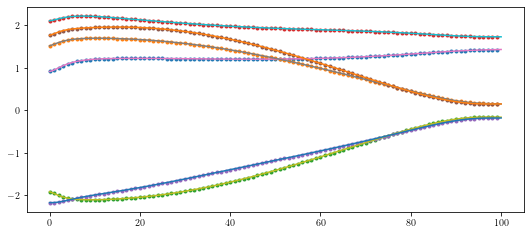

In [38]:
fig = plt.figure(figsize=(10, 5))
plt.plot(C.NN, C.XX[:, :6], ".")
plt.plot(C.NN3, C.XX_num[:, :6], "-")

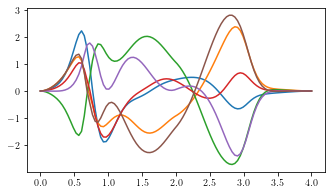

In [39]:
plt.plot(C.tt, C.XXdd_n[:, :6], "-")

---

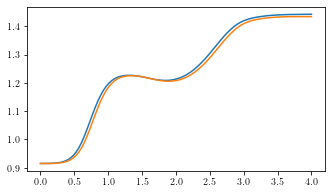

In [40]:
q = C.XXdd_n[:, 0]
dt = C.tt[1] ##:

qq = npy.cumsum(npy.cumsum(q))*dt**2

plt.plot(C.tt, C.XX_num[0, 0]+qq)
plt.plot(C.tt, C.XX_num[:, 0])




Calculate:
$$
D(\theta, \dot \theta, \ddot \theta) := M(\theta) \ddot \theta + C(\theta, \dot \theta) + K(\theta)
$$

which can then be used to calculate the right hand side
$$
RHS = - A^T(\theta) \lambda + B(\theta) \tau
$$



In [41]:
expr = mod.eqns.subz0(mod.uu, mod.llmd).subs(parameter_values)
dynterm_func = st.expr_to_func(ttheta_all, expr)

In [42]:
def get_torques(dyn_term_func, XX_derivs, static1=False, static2=False):
        
    ttheta_num_all = npy.c_[XX_derivs.XX_num[:, :n], XX_derivs.XXd_n[:, :n], XX_derivs.XXdd_n[:, :n]] ##:S
    
    if static1:
        # set velocities to 0
        ttheta_num_all[:, n:2*n] = 0
    
    if static2:
        # set accelerations to 0
        ttheta_num_all[:, 2*n:] = 0
    
        
    res = dynterm_func(*ttheta_num_all.T)
    return res

---

info(lhs_static) := "<class 'numpy.ndarray'> with shape: (100, 6)"

---

---

info(lhs_dynamic) := "<class 'numpy.ndarray'> with shape: (100, 6)"

---

Text(0.5, 1.0, 'static vs. dynamic LHS')

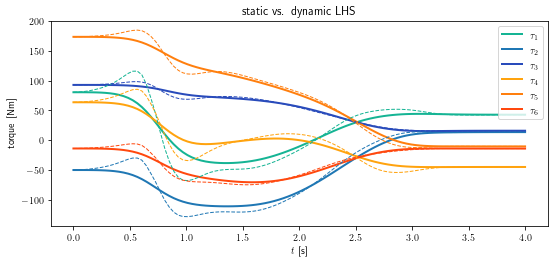

In [43]:
# Check if in the static case we get the same values for ttau and llmd as with casadi: 

lhs_static = get_torques(dynterm_func, XX_derivs, static1=True, static2=True) ##:i
lhs_dynamic = get_torques(dynterm_func, XX_derivs, static2=False) ##:i


# already defined above
# color_cycle = cycler(color=['#1F77B4', '#294BBB', '#15B494', '#ff7f0e', '#FFA30E', '#FF480E'])

plt.figure(figsize=(10,5))

plt.gca().set_prop_cycle(color_cycle)
plt.plot(XX_derivs.tt, lhs_static, "-", lw=2)
axis = plt.axis()
plt.plot(XX_derivs.tt, lhs_dynamic, "--", lw=1)

plt.xlabel("$t$ [s]")
plt.ylabel("torque [Nm]")
plt.legend(["$\\tau_1$", "$\\tau_2$", "$\\tau_3$", "$\\tau_4$", "$\\tau_5$", "$\\tau_6$"])

# plt.axis(axis)

plt.title("static vs. dynamic LHS")

---

---

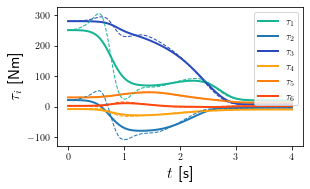

In [44]:
# probe: Optimierungsproblem lösen muss für statischen Fall ähnliches Ergebnis wie bisheriges bringen
# (vermutlich nicht gleich, weil bisher die Kostenfunktion noch mehr Terme enthielt)


mmu_stat_list = []
mmu_dyn_list = []
for L_k_stat, L_k_dyn, ttheta_k in zip(lhs_static, lhs_dynamic, XX_derivs.XX_num[:, :n]):
    K1_k = K1_func(*ttheta_k)
    mmu_stat_k = solve_qlp(L_k_stat, K1_k, rho)
    mmu_stat_list.append(mmu_stat_k)
    
    mmu_dyn_k = solve_qlp(L_k_dyn, K1_k, rho)
    mmu_dyn_list.append(mmu_dyn_k)
    
mmu_stat_all = npy.array(mmu_stat_list) ##:S
mmu_dyn_all = npy.array(mmu_dyn_list) ##:S

plt.rcParams['text.usetex'] = True
plt.rcParams["axes.labelsize"] = 16

plt.rcParams['figure.subplot.bottom'] = .22
plt.rcParams['figure.subplot.left'] = .18
plt.rcParams['figure.subplot.top'] = .92
plt.rcParams['figure.subplot.right'] = .97


mm = 1./25.4 #mm to inch
scale = 2
fs = [55*mm*scale, 35*mm*scale]
plt.figure(figsize=fs)

plt.gca().set_prop_cycle(color_cycle)
plt.plot(XX_derivs.tt, mmu_stat_all[:, :n], "-", lw=2)

plt.gca().set_prop_cycle(color_cycle)
plt.plot(XX_derivs.tt, mmu_dyn_all[:, :n], "--", lw=1)


# plt.gca().set_prop_cycle(color_cycle)
# plt.plot(XX_derivs.tt, XX_derivs.XX_num[:, 6:-2], ":")

plt.xlabel(r"$t$ [s]")
plt.ylabel(r"$\tau_i$ [Nm]")
plt.legend(["$\\tau_1$", "$\\tau_2$", "$\\tau_3$", "$\\tau_4$", "$\\tau_5$", "$\\tau_6$"])

plt.savefig("static_vs_dynamic_torques.pdf")

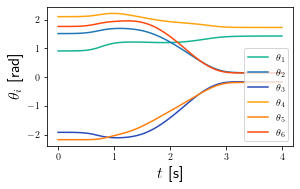

In [45]:

plt.figure(figsize=fs)

plt.gca().set_prop_cycle(color_cycle)
plt.plot(XX_derivs.tt, XX_derivs.XX_num[:, :6], "-")


plt.xlabel(r"$t$ [s]")
plt.ylabel(r"$\theta_i$ [rad]")
plt.legend(["$\\theta_1$", "$\\theta_2$", "$\\theta_3$", "$\\theta_4$", "$\\theta_5$", "$\\theta_6$"], loc="lower right")


plt.savefig("joint_angles.pdf")

In [46]:


plt.rcParams["text.latex.preamble"]

plt.rcParams["font.family"]# ="serif"

['sans-serif']

In [47]:
ipydex.dirsearch("font", plt.rcParams)

('font.cursive',
 'font.family',
 'font.fantasy',
 'font.monospace',
 'font.sans-serif',
 'font.serif',
 'font.size',
 'font.stretch',
 'font.style',
 'font.variant',
 'font.weight',
 'legend.fontsize',
 'legend.title_fontsize',
 'mathtext.fontset',
 'pdf.fonttype',
 'pdf.use14corefonts',
 'pgf.rcfonts',
 'ps.fonttype',
 'svg.fonttype')

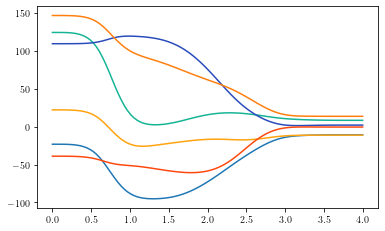

In [48]:
plt.gca().set_prop_cycle(color_cycle)
plt.plot(XX_derivs.tt, XX_derivs.XX_num[:, 6:-2])

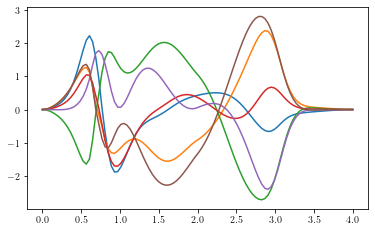

In [49]:
plt.plot(XX_derivs.tt, XX_derivs.XXdd_n[:, :6])

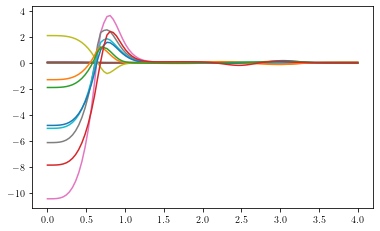

In [50]:
plt.plot(XX_derivs.tt, XX_derivs.XXdd_num)

In [51]:
ttheta_num_all = npy.c_[XX_derivs.XX_num[:, :n], XX_derivs.XXd_n[:, :n], XX_derivs.XXdd_n[:, :n]] ##:S

---

In [52]:
dynterm_func(*ttheta_num_all.T) ##:S

---

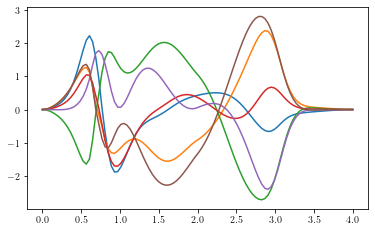

In [53]:
plt.plot(C.tt, C.XXdd_n[:, :6], "-")

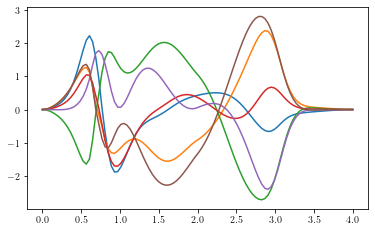

In [54]:
plt.plot(XX_derivs.tt, XX_derivs.XXdd_n[:, :6])

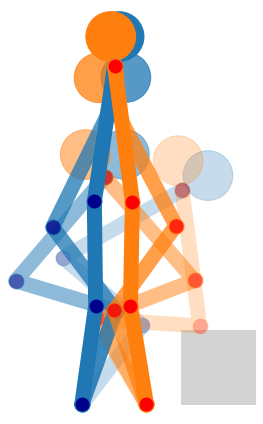

In [55]:
# frames = [0, 50, 120, 199] # for N=200
frames = [0, 25, 60, 99]

ttheta_onion = XX[:, :6]
ttheta_onion = ttheta_onion[frames, :]

fig, ax = vis.create_default_axes()
fig.set_size_inches(4, 6)
ax.grid(False)
ax.set_axis_off()
ax.set_xlim(-0.3, 0.7)
ax.set_ylim(-0.05, 1.6)

# draw chair
from matplotlib.patches import Rectangle
chair = Rectangle((0.4, 0), 1, 0.3, color="lightgray")
ax.add_patch(chair)

# plot onion skins
# change_alpha=True tweaks the alpha channel, change_alpha=False tweaks the color lightness
vis.plot_onion_skinned(ttheta_onion, axes=ax, change_alpha=True, max_lightness=0.75)

plt.tight_layout()

plt.savefig("assisted_standup_anim.pdf")